# Assignment-3: Apply K-NN on Amazon Fine Food Reviews DataSet 

# 1.0 Introduction 

(i).The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression predictive problem.

(ii).It is more widely used in classification problems in the industry. 

# 2.0 Objective

To Predict the Polarity of Amazon Fine Food Review Using K-Nearst Neighbour Algorithm.

# 3.0 Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 4.0 Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


# 5.0 Information About DataSet

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


### 5.1  Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

## 6.0 Due to Limited Hardware Resource we will limit our analysis on 20000 data     points only.

In [6]:
# To randomly sample 10k points from both class

data_pos = Data[Data["Score"] == 1].sample(n = 10000)
data_neg = Data[Data["Score"] == 0].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])
final_20k.shape

(20000, 12)

In [7]:
Y = final_20k['Score'].values
X = final_20k['CleanedText'].values

###  7.0 Splitting DataSet into Train and Test Data

In [8]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting

print("Shape of Train and Test Dataset")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Shape of Train and Test Dataset
(13400,) (13400,)
(6600,) (6600,)


# 8.0 Defining Some Function

### 8.1 Train Data Confusion Matrix Plot

In [9]:
def trainconfusionmatrix(knn,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, knn.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 8.2 Test Data Confusion Matrix Plot

In [10]:
def testconfusionmatrix(knn,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, knn.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 8.3 ROC-AUC Curve Plot

In [11]:
def plot_auc_roc(knn,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### 8.4 Error Plot

In [12]:
def error_plot(neighbours,mse):
    plt.title('Error Plot')
    plt.xlabel('K')
    plt.ylabel('misscalssifiaction error')
    plt.plot(neighbours,mse)

### 8.5 Cross Validation Using Kd Tree Algorithm

In [13]:
def knn_cv_kd(X_train,y_train,neighbours):
    
    cv_scores=[]
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

### 8.6 Cross Validation Using Brute Algorithm 

In [14]:
def knn_cv_brute(X_train,y_train,neighbours):
    
    cv_scores=[]
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

### 8.7 Accuracy 

In [15]:
def accuracy(model,X_train,Y_train,X_test,Y_test):
    prediction=model.predict(X_test)
    
    training_accuracy=model.score(X_train,Y_train)  # accuracy_score(y_train ,neigh.predict(X_train))
    training_error=1-training_accuracy
    
    test_accuracy=accuracy_score(Y_test,prediction)
    test_error=1-test_accuracy
    return training_accuracy,training_error,test_accuracy,test_error

# 9.0 Bags of Words

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("Shape of Train , Test and Cross Validation Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train , Test and Cross Validation Data After vectorizations
(13400, 15042) (13400,)
(6600, 15042) (6600,)


In [17]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

### 9.1 Brute Force Algorithm

#### 9.1.1  Finding Optimal Value of Hyperparameter(k) 

In [18]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_bow,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  55


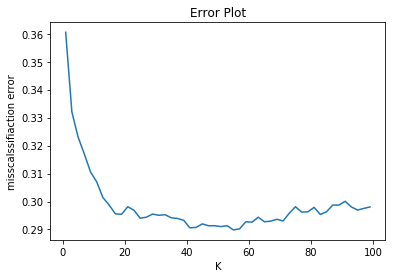

In [19]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 9.1.2 Training the model 

In [20]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_bow, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=55, p=2,
           weights='uniform')

#### 9.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot 

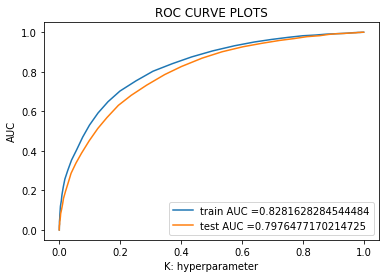

In [21]:
plot_auc_roc(neigh,X_train_bow,X_test_bow,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data 

Confusion Matrix for Train set


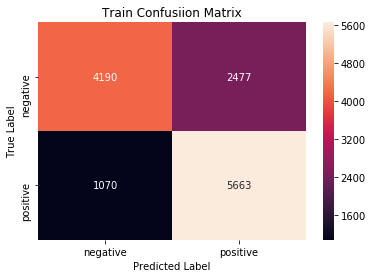

In [22]:
trainconfusionmatrix(neigh,X_train_bow,y_train)

##### (C). Confusion Matrix on Test Data 

Confusion Matrix for Test set


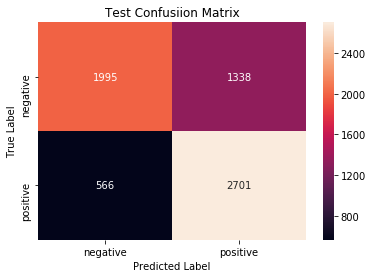

In [23]:
testconfusionmatrix(neigh,X_test_bow,y_test)

##### (D). Accuracy and Error

In [24]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_bow,y_train,X_test_bow,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  74.0

Train Error in %:  26.0

Test Accuracy in %:  71.0

Test Error in % :  28.999999999999996


##### (E). Classification Report

In [25]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_bow)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.60      0.68      3333
           1       0.67      0.83      0.74      3267

   micro avg       0.71      0.71      0.71      6600
   macro avg       0.72      0.71      0.71      6600
weighted avg       0.72      0.71      0.71      6600



###  9.2 KD-Tree Algorithm

#### 9.2.1 Finding Optimal Value of Hyperparameter(k)

In [26]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_bow,y_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  55


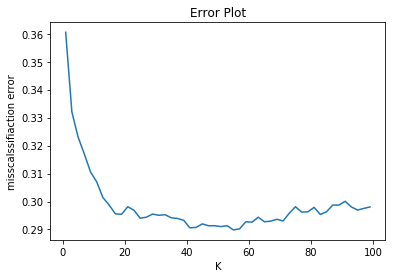

In [27]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 9.2.2 Training the model

In [28]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_bow, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=55, p=2,
           weights='uniform')

#### 9.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

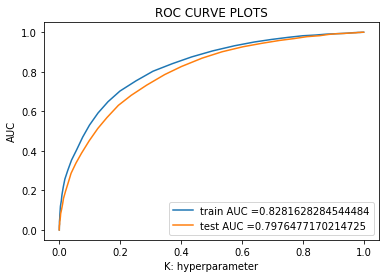

In [29]:
plot_auc_roc(neigh,X_train_bow,X_test_bow,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


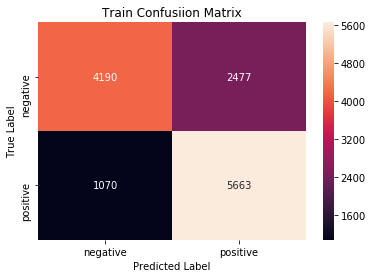

In [30]:
trainconfusionmatrix(neigh,X_train_bow,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


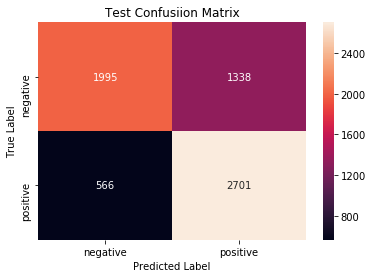

In [31]:
testconfusionmatrix(neigh,X_test_bow,y_test)

##### (D). Accuracy and Error 

In [32]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_bow,y_train,X_test_bow,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  74.0

Train Error in %:  26.0

Test Accuracy in %:  71.0

Test Error in % :  28.999999999999996


##### (E). Classification Report

In [33]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_bow)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.60      0.68      3333
           1       0.67      0.83      0.74      3267

   micro avg       0.71      0.71      0.71      6600
   macro avg       0.72      0.71      0.71      6600
weighted avg       0.72      0.71      0.71      6600



# 10.0 TF-IDF

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_TF = vectorizer.transform(X_train)
X_test_TF = vectorizer.transform(X_test)

In [35]:
print("After vectorizations")
print(X_train_TF.shape, y_train.shape)
print(X_test_TF.shape, y_test.shape)

After vectorizations
(13400, 304884) (13400,)
(6600, 304884) (6600,)


### 10.1 Brute Force Algorithm

#### 10.1.1 Finding Optimal Value of Hyperparameter(k)

In [36]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_TF,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  97


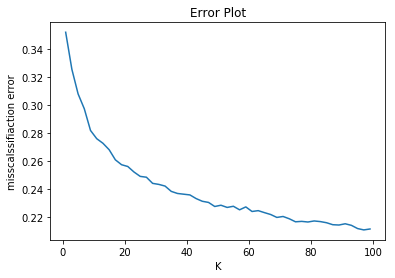

In [37]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

##### 10.1.2 Training the model 

In [38]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_TF, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=97, p=2,
           weights='uniform')

#### 10.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

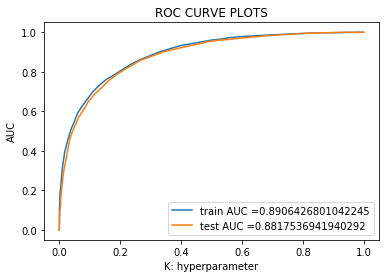

In [39]:
plot_auc_roc(neigh,X_train_TF,X_test_TF,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


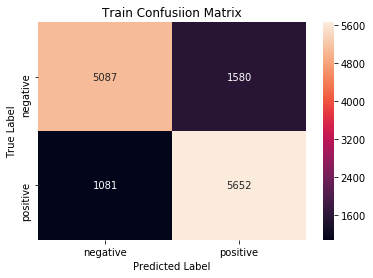

In [40]:
trainconfusionmatrix(neigh,X_train_TF,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


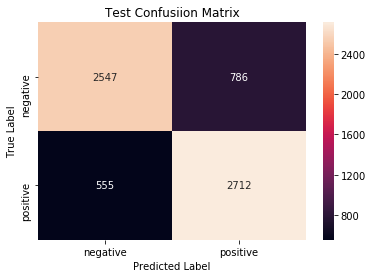

In [41]:
testconfusionmatrix(neigh,X_test_TF,y_test)

##### (D). Accuracy and Error

In [42]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_TF,y_train,X_test_TF,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  80.0

Train Error in %:  20.0

Test Accuracy in %:  80.0

Test Error in % :  20.0


##### (E). Classification Report

In [43]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TF)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      3333
           1       0.78      0.83      0.80      3267

   micro avg       0.80      0.80      0.80      6600
   macro avg       0.80      0.80      0.80      6600
weighted avg       0.80      0.80      0.80      6600



### 10.2 KD Tree Algorithm

#### 10.2.1 Finding Optimal Value of Hyperparameter(k)

In [44]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_TF,y_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  97


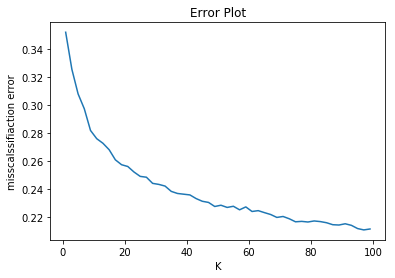

In [45]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

##### 10.2.2 Training the model

In [46]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_TF, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=97, p=2,
           weights='uniform')

##### 10.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

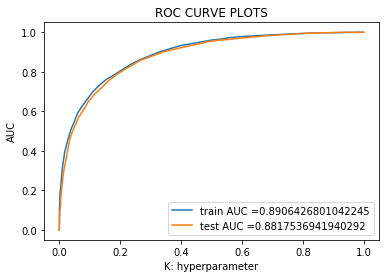

In [47]:
plot_auc_roc(neigh,X_train_TF,X_test_TF,y_train,y_test)

###### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


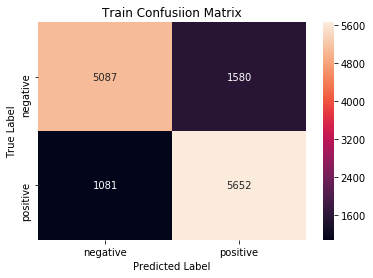

In [48]:
trainconfusionmatrix(neigh,X_train_TF,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


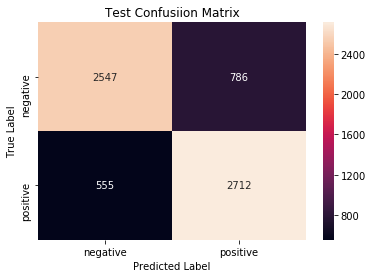

In [49]:
testconfusionmatrix(neigh,X_test_TF,y_test)

##### (D). Accuracy and Error

In [50]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_TF,y_train,X_test_TF,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  80.0

Train Error in %:  20.0

Test Accuracy in %:  80.0

Test Error in % :  20.0


##### (E). Classification Report

In [51]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TF)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      3333
           1       0.78      0.83      0.80      3267

   micro avg       0.80      0.80      0.80      6600
   macro avg       0.80      0.80      0.80      6600
weighted avg       0.80      0.80      0.80      6600



# 11.0 Word To Vector

In [16]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [17]:
len(list_of_Train_sent)

13400

In [18]:
Train_model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)
Test_model=Word2Vec(list_of_Test_sent,min_count=5,size=50, workers=4)

### 11.1 Avg Word2Vec


In [55]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = Train_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [56]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=Test_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [57]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (6600, 50)


In [58]:
X_train_AWV = Train_vectors
X_test_AWV = Test_vectors

In [59]:
print(X_train_AWV.shape, y_train.shape)
print(X_test_AWV.shape, y_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


### 10.2 Brute Force Algorithm

#### 10.2.1 Finding Optimal Value of Hyperparameter(k)

In [60]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_AWV,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  37


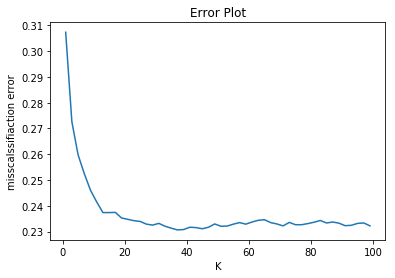

In [61]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 10.2.2 Training the model

In [62]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_AWV, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=37, p=2,
           weights='uniform')

##### 10.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

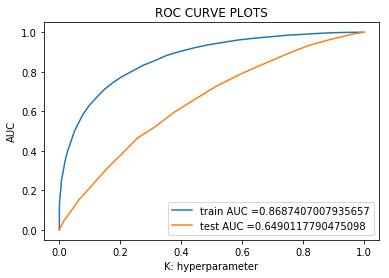

In [63]:
plot_auc_roc(neigh,X_train_AWV,X_test_AWV,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


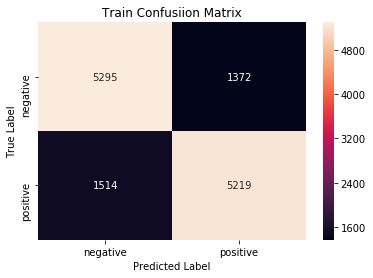

In [64]:
trainconfusionmatrix(neigh,X_train_AWV,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


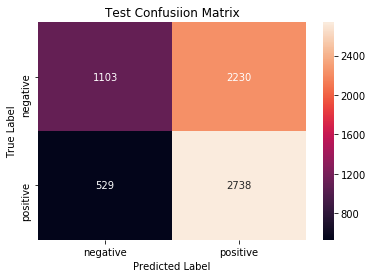

In [65]:
testconfusionmatrix(neigh,X_test_AWV,y_test)

##### (D). Accuracy and Error

In [66]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_AWV,y_train,X_test_AWV,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  78.0

Train Error in %:  22.0

Test Accuracy in %:  57.99999999999999

Test Error in % :  42.0


#### (E). Classification Report

In [67]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_AWV)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.68      0.33      0.44      3333
           1       0.55      0.84      0.66      3267

   micro avg       0.58      0.58      0.58      6600
   macro avg       0.61      0.58      0.55      6600
weighted avg       0.61      0.58      0.55      6600



### 10.3 KD Tree Algorithm

#### 10.3.1 Finding Optimal Value of Hyperparameter(k)

In [68]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_AWV,y_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  37


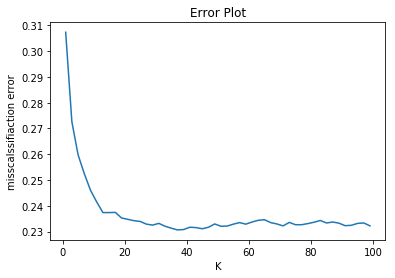

In [69]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 10.3.2 Training the model

In [70]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_AWV, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=37, p=2,
           weights='uniform')

#### 10.3.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

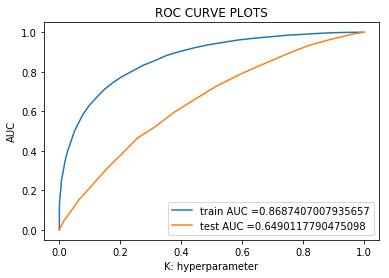

In [71]:
plot_auc_roc(neigh,X_train_AWV,X_test_AWV,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


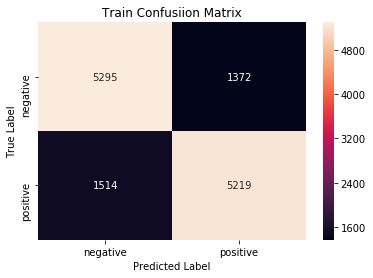

In [72]:
trainconfusionmatrix(neigh,X_train_AWV,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


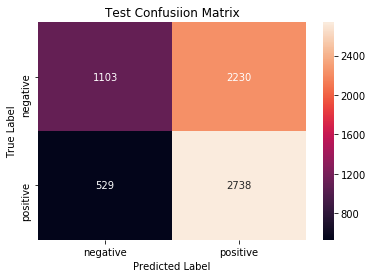

In [73]:
testconfusionmatrix(neigh,X_test_AWV,y_test)

##### (D). Accuracy and Error

In [74]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_AWV,y_train,X_test_AWV,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  78.0

Train Error in %:  22.0

Test Accuracy in %:  57.99999999999999

Test Error in % :  42.0


##### (E). Classification Report

In [75]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_AWV)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.68      0.33      0.44      3333
           1       0.55      0.84      0.66      3267

   micro avg       0.58      0.58      0.58      6600
   macro avg       0.61      0.58      0.55      6600
weighted avg       0.61      0.58      0.55      6600



# 11.0 TF-IDF Word To Vector

In [19]:
model = TfidfVectorizer()
model.fit(X_train)
X_Train_TF = model.transform(X_train)
X_Test_TF = model.transform(X_test)

In [20]:
print("Shape of Train Data After TFIDF : ",X_Train_TF.shape)
print("Shape of Test Data After TFIDF : ",X_Test_TF.shape)

Shape of Train Data After TFIDF :  (13400, 15367)
Shape of Test Data After TFIDF :  (6600, 15367)


In [21]:
TFIDF_Feature=model.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

15367
['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaahhhhhhhhhhhhhhhh', 'aaah', 'aafco', 'aah', 'aamazon', 'aback', 'abandon', 'abat', 'abc', 'abdomin', 'aberr', 'abhorr', 'abil', 'abl', 'abnorm', 'abod', 'abomin', 'abouit']


In [22]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=Train_model.wv[word]
            tfidf_vec=X_Train_TF[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 13400/13400 [02:56<00:00, 75.98it/s]


In [23]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=Test_model.wv[word]
            tfidf_vec=X_Test_TF(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|█████████████████████████████████████| 6600/6600 [01:03<00:00, 103.35it/s]


In [25]:
Test_tfidfw2v_vectors=np.nan_to_num(Test_TFIDF_W2V_Vectors)  
Train_tfidfw2v_vectors=np.nan_to_num(Train_TFIDF_W2V_Vectors)  

In [28]:
X_train_TfIdfW2v=Train_tfidfw2v_vectors
X_test_TfIdfW2v=Test_tfidfw2v_vectors

### 11.1 Brute Force Algorithm

#### 11.1.1 Finding Optimal Value of Hyperparameter(k) 

In [29]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_brute(X_train_TfIdfW2v,y_train,neighbours)

Best value of K found for Brute Force Algorithm Implementaion is :  95


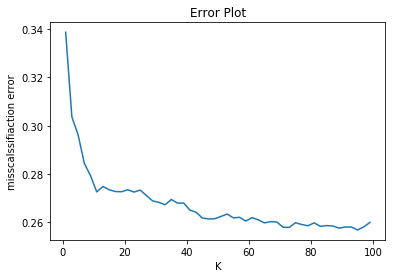

In [30]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Algorithm Implementaion is : ",best_k)

#### 11.1.2 Training the model

In [33]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_TfIdfW2v, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=95, p=2,
           weights='uniform')

#### 11.1.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

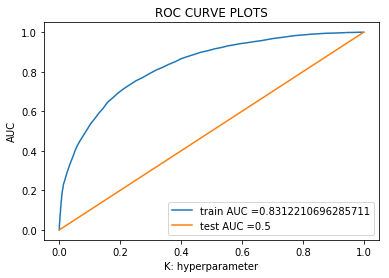

In [34]:
plot_auc_roc(neigh,X_train_TfIdfW2v,X_test_TfIdfW2v,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


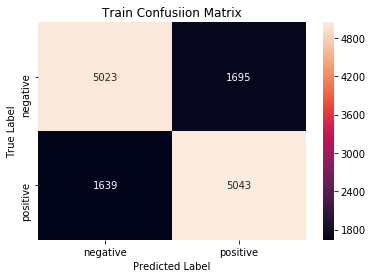

In [35]:
trainconfusionmatrix(neigh,X_train_TfIdfW2v,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


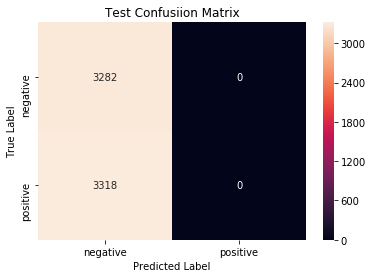

In [36]:
testconfusionmatrix(neigh,X_test_TfIdfW2v,y_test)

##### (D). Accuracy and Error

In [37]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_TfIdfW2v,y_train,X_test_TfIdfW2v,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  75.0

Train Error in %:  25.0

Test Accuracy in %:  50.0

Test Error in % :  50.0


##### (E). Classification Report

In [38]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TfIdfW2v)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      3282
           1       0.00      0.00      0.00      3318

   micro avg       0.50      0.50      0.50      6600
   macro avg       0.25      0.50      0.33      6600
weighted avg       0.25      0.50      0.33      6600



### 11.2 KD Tree Algorithm

#### 11.2.1 Finding Optimal Value of Hyperparameter(k)

In [39]:
import numpy as np 

neighbours=np.arange(1,100,2)
mse,best_k = knn_cv_kd(X_train_TfIdfW2v,y_train,neighbours)

Best value of K found for KD Tree Algorithm Implementaion is :  95


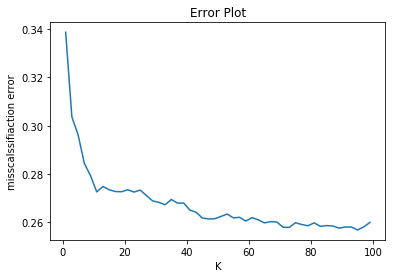

In [40]:
error_plot(neighbours,mse)
print("Best value of K found for KD Tree Algorithm Implementaion is : ",best_k)

#### 11.2.2 Training the model

In [41]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_TfIdfW2v, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=95, p=2,
           weights='uniform')

#### 11.2.3 Evaluting the performance of model

##### (A). Roc-Auc Plot

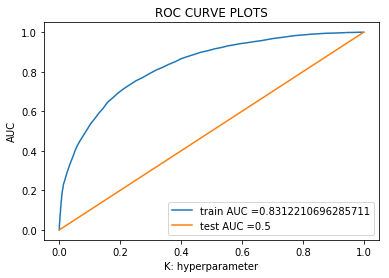

In [42]:
plot_auc_roc(neigh,X_train_TfIdfW2v,X_test_TfIdfW2v,y_train,y_test)

##### (B). Confusion Matrix Plot on Train Data

Confusion Matrix for Train set


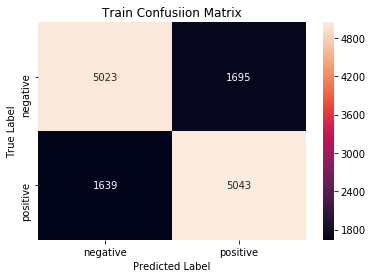

In [43]:
trainconfusionmatrix(neigh,X_train_TfIdfW2v,y_train)

##### (C). Confusion Matrix Plot on Test Data

Confusion Matrix for Test set


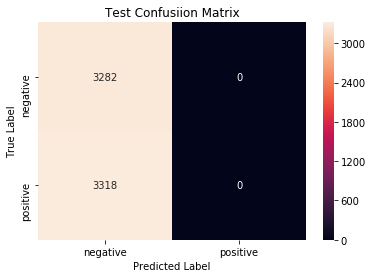

In [44]:
testconfusionmatrix(neigh,X_test_TfIdfW2v,y_test)

##### (D). Accuracy and Error

In [45]:
training_accuracy,training_error,test_accuracy,test_error = accuracy(neigh,X_train_TfIdfW2v,y_train,X_test_TfIdfW2v,y_test)
print("Training Accuracy in %: ", round(training_accuracy,2)*100)
print("\nTrain Error in %: ", round(training_error,2)*100)
print("\nTest Accuracy in %: ", round(test_accuracy,2)*100)
print("\nTest Error in % : ", round(test_error,2)*100)

Training Accuracy in %:  75.0

Train Error in %:  25.0

Test Accuracy in %:  50.0

Test Error in % :  50.0


##### (E). Classification Report

In [46]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TfIdfW2v)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      3282
           1       0.00      0.00      0.00      3318

   micro avg       0.50      0.50      0.50      6600
   macro avg       0.25      0.50      0.33      6600
weighted avg       0.25      0.50      0.33      6600



# 12.0 Conclusion :

#### 1. Report On Brute Force Algorithm

In [51]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter", "AUC","Train Accuracy (%)","Test Accuracy (%)"]

x.add_row(["BOW",55,0.79,74,71])
x.add_row(["TF-IDF", 97,0.88,80,80])
x.add_row(["W2V",37,0.64,78,57 ])
x.add_row(["TF-IDF W2V",95,0.50,75,50])
print(x)

+------------+----------------+------+--------------------+-------------------+
| Vectorizer | Hyperparameter | AUC  | Train Accuracy (%) | Test Accuracy (%) |
+------------+----------------+------+--------------------+-------------------+
|    BOW     |       55       | 0.79 |         74         |         71        |
|   TF-IDF   |       97       | 0.88 |         80         |         80        |
|    W2V     |       37       | 0.64 |         78         |         57        |
| TF-IDF W2V |       95       | 0.5  |         75         |         50        |
+------------+----------------+------+--------------------+-------------------+


##### 2. Report on KD Tree Algorithm

In [52]:
x = PrettyTable()

x.field_names = ["Vectorizer","Hyperparameter", "AUC","Train Accuracy (%)","Test Accuracy (%)"]

x.add_row(["BOW",55,0.79,74,71])
x.add_row(["TF-IDF",97,0.88,80,80])
x.add_row(["W2V",37,0.64,78,57 ])
x.add_row(["TF-IDF W2V",95,0.50,75,50])
print(x)

+------------+----------------+------+--------------------+-------------------+
| Vectorizer | Hyperparameter | AUC  | Train Accuracy (%) | Test Accuracy (%) |
+------------+----------------+------+--------------------+-------------------+
|    BOW     |       55       | 0.79 |         74         |         71        |
|   TF-IDF   |       97       | 0.88 |         80         |         80        |
|    W2V     |       37       | 0.64 |         78         |         57        |
| TF-IDF W2V |       95       | 0.5  |         75         |         50        |
+------------+----------------+------+--------------------+-------------------+


#### 3.  71 % Of Accuracy is achieved by the model in case of Bag of Words.

#### 4. 80 % Of Accuracy is achieved by the model in case of TF-IDF Vectorizer.

#### 5. Model is overfit in case of Average Word to vector. 

#### 6. Very small subset of Data is  taken but still it took more time due to large dimension and time complexity of KNN.

#### 7. Model behaviour in TF-IDF W2V is lenint towards one class .